## Navigating Customer Sentiments: An Analysis of British Airways' Passenger Experiences (2018-2023)


British Airways (BA) serves as the United Kingdom's flag carrier airline, orchestrating thousands of flights daily that connect the UK with destinations worldwide. Whether it's leisurely holidays, business trips, or any other travel needs, managing the intricate processes of scheduling, planning, boarding, fuelling, transporting, and ensuring punctual arrivals and departures is a monumental task filled with vital responsibilities.

My objective in this analysis is to employ analytical techniques to delve into the customers' experiences, feelings, and feedback regarding BA's services. By understanding these insights, we can potentially uncover areas for enhancement, align services with customer expectations, and foster a travel experience that resonates with BA's commitment to excellence.

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
pd.set_option("display.max_colwidth", 100)
import matplotlib.pyplot as plt
import seaborn as sns

### Data Collection

The code block below is designed to scrape customer reviews for British Airways from the website "<a>www.airlinequality.com</a>." It covers multiple pages of reviews, and for each review, it gathers information about the content of the review, the type of traveller (e.g., business or leisure), the seat type, and the date the review was posted.

Initialization: The base_url contains the URL for the British Airways reviews on the website, and the pages and page_size variables define how many pages and reviews per page will be scraped. Lists to store the reviews, type of traveller, date, and seat type are initialized.

Page Loop: A loop is used to iterate through the specified number of pages. Within each iteration:
a. URL Creation: A unique URL is constructed for each page based on the page number and page size.
b. Requesting and Parsing HTML Data: The requests.get(url) method fetches the HTML content of the specified URL, and BeautifulSoup is used to parse the HTML.
c. Extracting Reviews: The parsed content is searched for specific HTML elements corresponding to the reviews and details about the customer. The find_all and find methods are used to extract this information.
d. Collecting Customer Details: Nested loops and conditional statements identify specific details about each review, including the type of traveller, seat type, and date flown.

Results: The scraped data is stored in the corresponding lists (reviews, type_of_traveller, date, seat_type), providing a rich dataset of customer opinions and associated metadata that can be used for analysis.

In [3]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []
type_of_traveller = []
date = []
seat_type = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"



# Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    first_search = list(parsed_content.find_all("div", attrs = {"class": "tc_mobile"})) 

    for w in range(0, len(first_search)):
        #Customer review
        reviews.append(first_search[w].find("div", attrs = {"class": "text_content"}).get_text())
        #Details about the customer
        second_search = first_search[w].find_all("td")

        for j in range(0, len(second_search)):
            if second_search[j].get_text() == "Type Of Traveller":
                type_of_traveller.append(second_search[j+1].get_text())
            if second_search[j].get_text() == "Seat Type":
                seat_type.append(second_search[j+1].get_text())
            if second_search[j].get_text() == "Date Flown":
                date.append(second_search[j+1].get_text())
            

In [4]:
# len(reviews)

Creating a DataFrame to hold information on customer reviews for British Airways.
The DataFrame includes columns for the review text, type of traveller, date of the review, and seat type.

In [5]:
df = pd.DataFrame()
df["reviews"] = reviews
df['type of traveller'] = type_of_traveller
df['date'] = date
df['seat_type'] = seat_type
df.head(20)

In [6]:
df.to_csv("/Users/drizzytom/Documents/data/BA_reviews.csv") #save as CSV

### Analysis and Preprocessing 

In [7]:
import re
import nltk
import string 
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
df = pd.read_csv("BA_reviews.csv")

#### Data Cleaning 

In [9]:
list(df["reviews"][0:2])

['✅ Trip Verified |  Customer Service does not exist. One world emerald, frequent long haul flyer (including BA) - never seen such poor customer service or “computer says no”. Official BA.com site said all morning and afternoon that flight from Gatwick, delayed 2 hours. Delayed leaving for airport -only for BA to change back to original time. Called BA customer service 1.5 hours prior from highway saying situation - told not to worry, would note and flight rebooked if issue but go to airport. Got to airport 40 mins prior told could not board and that staff did not work for BA so could not help. Back on phone, 3 hours in total to be told could be rebooked, then couldn’t be, round and round. Ultimately told to file complaint. Then found out flight left 2 hours delayed. Paid for extra hotels flights with more competent airlines and now told 38 days wait for complaints to be responded to - heavens help economy and non-status flyers if that’s what the front end of the plane gets!',
 '✅ Trip

In [10]:
df["check"] = df['reviews'].apply(lambda x : x.split("|")[1])
df.drop("check", axis=1, inplace =True)

In [11]:
df['reviews_clean'] = df['reviews'].apply(lambda x : x.split("|")[1]) #Removed "Trip Verified" from the reviews 

In [12]:
df.head()

,Unnamed: 0,reviews,type of traveller,date,seat_type,reviews_clean
0,0,"✅ Trip Verified | Customer Service does not exist. One world emerald, frequent long haul flyer ...",Family Leisure,July 2023,Business Class,"Customer Service does not exist. One world emerald, frequent long haul flyer (including BA) - ..."
1,1,"✅ Trip Verified | Another really great pair of flights, on time, no problems at all, champagne w...",Family Leisure,June 2023,Business Class,"Another really great pair of flights, on time, no problems at all, champagne was ok and my meal..."
2,2,Not Verified | Our A380 developed a fault taxiing to the runway - we returned to the gate only ...,Solo Leisure,June 2023,Business Class,Our A380 developed a fault taxiing to the runway - we returned to the gate only to then have t...
3,3,Not Verified | Horrible airline. Does not care about their customers. Used to be decent but has ...,Solo Leisure,July 2023,Economy Class,Horrible airline. Does not care about their customers. Used to be decent but has now since real...
4,4,✅ Trip Verified | My family and I have flown mostly on British Airways for the last 30 years. I...,Couple Leisure,July 2023,Premium Economy,My family and I have flown mostly on British Airways for the last 30 years. I am a priority pa...


In [13]:
df['seat_type'].value_counts()

seat_type
Economy Class      561
Business Class     319
Premium Economy     89
First Class         31
Name: count, dtype: int64

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
def count_punct(text):
    """
    counting the percentage of punctuation in a review
    """
    count = sum([1 for char in text if char in string.punctuation])
    return round(count / (len(text) - text.count(" ")),3) * 100

In [16]:
df['punct%'] = df['reviews_clean'].apply(lambda x :count_punct(x) )

In [17]:
df.head()

,Unnamed: 0,reviews,type of traveller,date,seat_type,reviews_clean,punct%
0,0,"✅ Trip Verified | Customer Service does not exist. One world emerald, frequent long haul flyer ...",Family Leisure,July 2023,Business Class,"Customer Service does not exist. One world emerald, frequent long haul flyer (including BA) - ...",3.1
1,1,"✅ Trip Verified | Another really great pair of flights, on time, no problems at all, champagne w...",Family Leisure,June 2023,Business Class,"Another really great pair of flights, on time, no problems at all, champagne was ok and my meal...",2.9
2,2,Not Verified | Our A380 developed a fault taxiing to the runway - we returned to the gate only ...,Solo Leisure,June 2023,Business Class,Our A380 developed a fault taxiing to the runway - we returned to the gate only to then have t...,2.4
3,3,Not Verified | Horrible airline. Does not care about their customers. Used to be decent but has ...,Solo Leisure,July 2023,Economy Class,Horrible airline. Does not care about their customers. Used to be decent but has now since real...,2.9
4,4,✅ Trip Verified | My family and I have flown mostly on British Airways for the last 30 years. I...,Couple Leisure,July 2023,Premium Economy,My family and I have flown mostly on British Airways for the last 30 years. I am a priority pa...,2.4


**Removing Punctuations from the reviews**

In [18]:
def remove_punc(text):
    """
    A function to remove punctuations from the reviews
    """
    return "".join([word for word in text if word not in string.punctuation])

In [19]:
df["reviews_clean"] = df['reviews_clean'].apply(lambda x: remove_punc(x))

In [20]:
df_reviews = df[['reviews_clean']]

In [21]:
df_reviews.head()

,reviews_clean
0,Customer Service does not exist One world emerald frequent long haul flyer including BA never...
1,Another really great pair of flights on time no problems at all champagne was ok and my meal ch...
2,Our A380 developed a fault taxiing to the runway we returned to the gate only to then have th...
3,Horrible airline Does not care about their customers Used to be decent but has now since really...
4,My family and I have flown mostly on British Airways for the last 30 years I am a priority pas...


In [22]:
df_reviews = pd.concat([df_reviews, df['punct%']], axis = 1)

In [23]:
df_reviews

,reviews_clean,punct%
0,Customer Service does not exist One world emerald frequent long haul flyer including BA never...,3.1
1,Another really great pair of flights on time no problems at all champagne was ok and my meal ch...,2.9
2,Our A380 developed a fault taxiing to the runway we returned to the gate only to then have th...,2.4
3,Horrible airline Does not care about their customers Used to be decent but has now since really...,2.9
4,My family and I have flown mostly on British Airways for the last 30 years I am a priority pas...,2.4
...,...,...
995,Flew Madrid to London Heathrow The 767 is ancient and BA have clearly given up on hiding that f...,2.1
996,London Heathrow to Brindisi We weren’t expecting the long queue for Club Europe checkin but mi...,3.0
997,I have BA silver membership This promises fast track choice of seats at booking priority boardi...,2.4
998,Hamburg to London Initial flight from London cancelled from under us 3 days from departure and...,2.5


In [24]:
df_reviews.columns = ["review", "punct%"]

In [25]:
df_reviews['body_len'] = df_reviews['review'].apply(lambda x: len(x) - x.count(" "))

In [26]:
df_reviews.columns

Index(['review', 'punct%', 'body_len'], dtype='object')

### Sentiment Analysis

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [28]:
sid.polarity_scores(df_reviews['review'].iloc[0])

{'neg': 0.099, 'neu': 0.836, 'pos': 0.066, 'compound': -0.7266}

### Adding Scores and Labels to the Dataframe 

In [29]:
df_reviews['polarity_scores'] = df['reviews_clean'].apply(lambda x : sid.polarity_scores(x))

In [30]:
df_reviews.head()

,review,punct%,body_len,polarity_scores
0,Customer Service does not exist One world emerald frequent long haul flyer including BA never...,3.1,772,"{'neg': 0.099, 'neu': 0.836, 'pos': 0.066, 'compound': -0.7266}"
1,Another really great pair of flights on time no problems at all champagne was ok and my meal ch...,2.9,238,"{'neg': 0.064, 'neu': 0.511, 'pos': 0.424, 'compound': 0.9808}"
2,Our A380 developed a fault taxiing to the runway we returned to the gate only to then have th...,2.4,845,"{'neg': 0.132, 'neu': 0.789, 'pos': 0.08, 'compound': -0.6936}"
3,Horrible airline Does not care about their customers Used to be decent but has now since really...,2.9,234,"{'neg': 0.125, 'neu': 0.875, 'pos': 0.0, 'compound': -0.7063}"
4,My family and I have flown mostly on British Airways for the last 30 years I am a priority pas...,2.4,1276,"{'neg': 0.036, 'neu': 0.886, 'pos': 0.077, 'compound': 0.919}"


In [31]:
#Take out only the Compound Score 

df_reviews['comp_score'] = df_reviews['polarity_scores'].apply(lambda x: x["compound"])

In [32]:
df_reviews

,review,punct%,body_len,polarity_scores,comp_score
0,Customer Service does not exist One world emerald frequent long haul flyer including BA never...,3.1,772,"{'neg': 0.099, 'neu': 0.836, 'pos': 0.066, 'compound': -0.7266}",-0.7266
1,Another really great pair of flights on time no problems at all champagne was ok and my meal ch...,2.9,238,"{'neg': 0.064, 'neu': 0.511, 'pos': 0.424, 'compound': 0.9808}",0.9808
2,Our A380 developed a fault taxiing to the runway we returned to the gate only to then have th...,2.4,845,"{'neg': 0.132, 'neu': 0.789, 'pos': 0.08, 'compound': -0.6936}",-0.6936
3,Horrible airline Does not care about their customers Used to be decent but has now since really...,2.9,234,"{'neg': 0.125, 'neu': 0.875, 'pos': 0.0, 'compound': -0.7063}",-0.7063
4,My family and I have flown mostly on British Airways for the last 30 years I am a priority pas...,2.4,1276,"{'neg': 0.036, 'neu': 0.886, 'pos': 0.077, 'compound': 0.919}",0.9190
...,...,...,...,...,...
995,Flew Madrid to London Heathrow The 767 is ancient and BA have clearly given up on hiding that f...,2.1,700,"{'neg': 0.046, 'neu': 0.651, 'pos': 0.303, 'compound': 0.9955}",0.9955
996,London Heathrow to Brindisi We weren’t expecting the long queue for Club Europe checkin but mi...,3.0,709,"{'neg': 0.092, 'neu': 0.817, 'pos': 0.091, 'compound': 0.2263}",0.2263
997,I have BA silver membership This promises fast track choice of seats at booking priority boardi...,2.4,730,"{'neg': 0.063, 'neu': 0.867, 'pos': 0.069, 'compound': 0.2516}",0.2516
998,Hamburg to London Initial flight from London cancelled from under us 3 days from departure and...,2.5,344,"{'neg': 0.214, 'neu': 0.745, 'pos': 0.041, 'compound': -0.8979}",-0.8979


In [33]:
def sentiment_label(score):
    if score > 0.05:
        return "positive"
    else:
        return "negative"
       

In [34]:
df_reviews["label"] = df_reviews['comp_score'].apply(lambda x: sentiment_label(x))

In [35]:
df_reviews.head()

,review,punct%,body_len,polarity_scores,comp_score,label
0,Customer Service does not exist One world emerald frequent long haul flyer including BA never...,3.1,772,"{'neg': 0.099, 'neu': 0.836, 'pos': 0.066, 'compound': -0.7266}",-0.7266,negative
1,Another really great pair of flights on time no problems at all champagne was ok and my meal ch...,2.9,238,"{'neg': 0.064, 'neu': 0.511, 'pos': 0.424, 'compound': 0.9808}",0.9808,positive
2,Our A380 developed a fault taxiing to the runway we returned to the gate only to then have th...,2.4,845,"{'neg': 0.132, 'neu': 0.789, 'pos': 0.08, 'compound': -0.6936}",-0.6936,negative
3,Horrible airline Does not care about their customers Used to be decent but has now since really...,2.9,234,"{'neg': 0.125, 'neu': 0.875, 'pos': 0.0, 'compound': -0.7063}",-0.7063,negative
4,My family and I have flown mostly on British Airways for the last 30 years I am a priority pas...,2.4,1276,"{'neg': 0.036, 'neu': 0.886, 'pos': 0.077, 'compound': 0.919}",0.9190,positive


In [36]:
df_reviews['label'].value_counts()

label
positive    504
negative    496
Name: count, dtype: int64

### Looking at the Negative Comments

In [37]:
df_reviews[df_reviews['label'] == 'negative'].sort_values(by = "comp_score").head()

,review,punct%,body_len,polarity_scores,comp_score,label
689,Hong Kong to Copenhagen via London The whole experience is a nightmare to me and my wife My wi...,1.9,2677,"{'neg': 0.116, 'neu': 0.874, 'pos': 0.01, 'compound': -0.9973}",-0.9973,negative
159,Vancouver to Delhi via London We were booked to fly from Vancouver to New Delhi via London Hea...,2.2,2562,"{'neg': 0.14, 'neu': 0.834, 'pos': 0.026, 'compound': -0.9965}",-0.9965,negative
151,Probably the worst business class experience Ive ever had on an airline Just a few of the issue...,3.6,2725,"{'neg': 0.11, 'neu': 0.88, 'pos': 0.01, 'compound': -0.9943}",-0.9943,negative
197,We boarded our flight at Edinburgh to London for our connecting flight to San Francisco on 4th...,2.4,1820,"{'neg': 0.131, 'neu': 0.84, 'pos': 0.029, 'compound': -0.9938}",-0.9938,negative
765,London to Nashville The worst airline TransAtlantic Despite looking forward to flying on this ...,3.2,912,"{'neg': 0.228, 'neu': 0.754, 'pos': 0.018, 'compound': -0.9925}",-0.9925,negative


#### Checking the Distribution for Review_len and Punct%

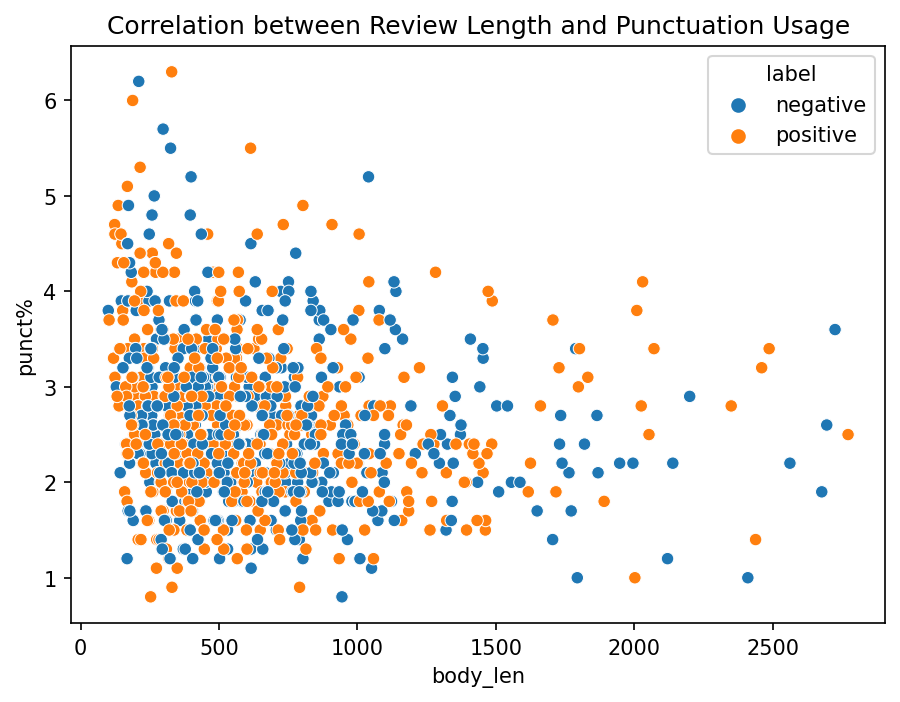

In [38]:
plt.figure(figsize = (7,5), dpi =150)
sns.scatterplot(data = df_reviews, x='body_len', y='punct%', hue = 'label')
plt.title("Correlation between Review Length and Punctuation Usage")
plt.show()

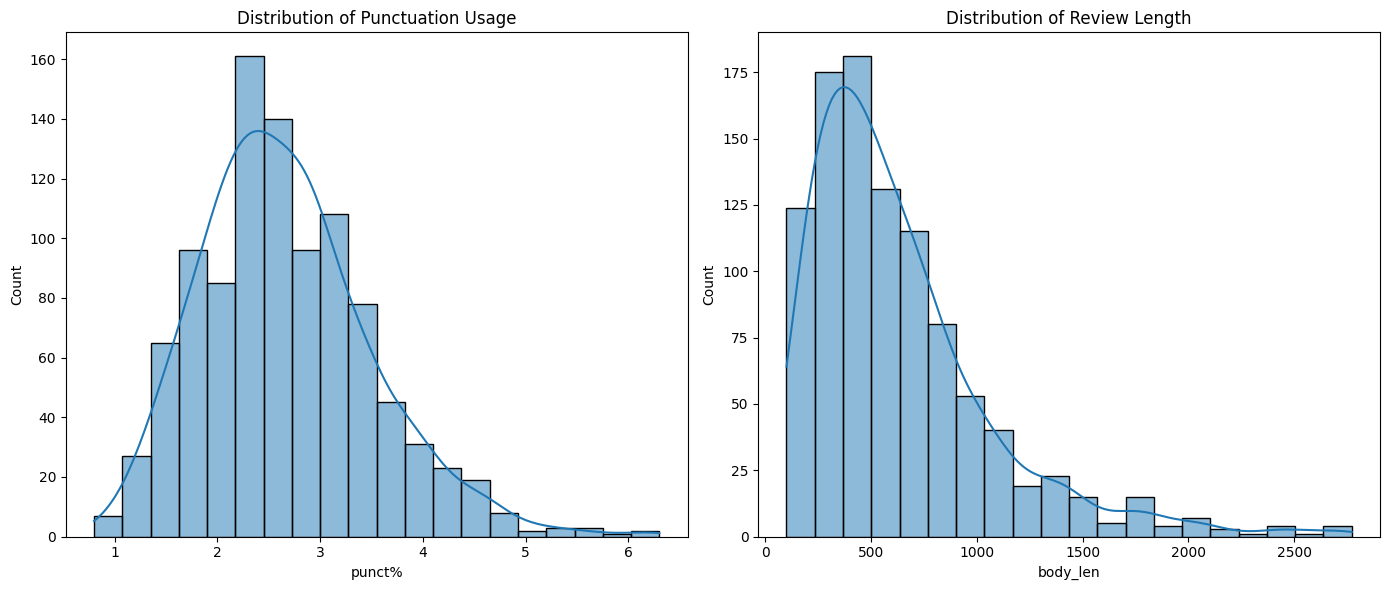

In [39]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(df_reviews['punct%'], bins=20, kde=True)
plt.title('Distribution of Punctuation Usage')

plt.subplot(1,2,2)
sns.histplot(df_reviews['body_len'], bins=20, kde=True)
plt.title('Distribution of Review Length')

plt.tight_layout()
plt.show()

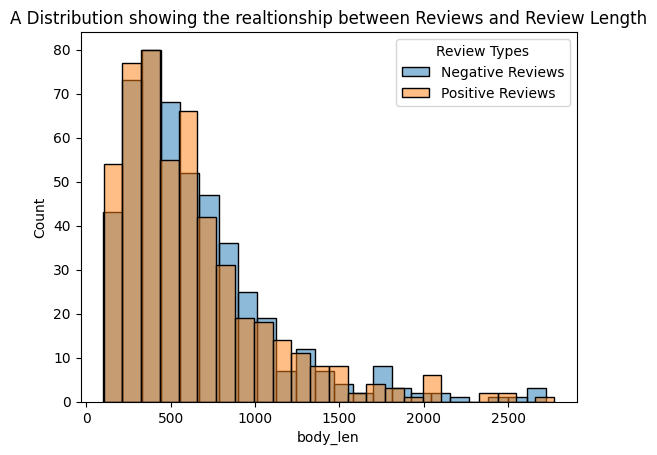

In [40]:
sns.histplot(data = df_reviews[df_reviews['label'] == 'negative']['body_len'], alpha = 0.5, label = 'Negative Reviews')
sns.histplot(data = df_reviews[df_reviews['label'] == 'positive']['body_len'], alpha = 0.5, label ='Positive Reviews')
plt.title("A Distribution showing the realtionship between Reviews and Review Length")
plt.legend(title= "Review Types")
plt.show()

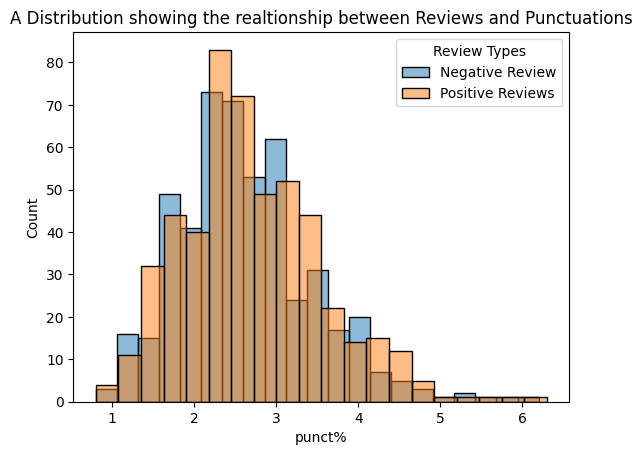

In [41]:
sns.histplot(data = df_reviews[df_reviews['label'] == 'negative']['punct%'], alpha = 0.5, label = "Negative Review")
sns.histplot(data = df_reviews[df_reviews['label'] == 'positive']['punct%'], alpha = 0.5, label = "Positive Reviews")
plt.title("A Distribution showing the realtionship between Reviews and Punctuations")
plt.legend(title= "Review Types")
plt.show()

In [42]:
df_reviews.head()

,review,punct%,body_len,polarity_scores,comp_score,label
0,Customer Service does not exist One world emerald frequent long haul flyer including BA never...,3.1,772,"{'neg': 0.099, 'neu': 0.836, 'pos': 0.066, 'compound': -0.7266}",-0.7266,negative
1,Another really great pair of flights on time no problems at all champagne was ok and my meal ch...,2.9,238,"{'neg': 0.064, 'neu': 0.511, 'pos': 0.424, 'compound': 0.9808}",0.9808,positive
2,Our A380 developed a fault taxiing to the runway we returned to the gate only to then have th...,2.4,845,"{'neg': 0.132, 'neu': 0.789, 'pos': 0.08, 'compound': -0.6936}",-0.6936,negative
3,Horrible airline Does not care about their customers Used to be decent but has now since really...,2.9,234,"{'neg': 0.125, 'neu': 0.875, 'pos': 0.0, 'compound': -0.7063}",-0.7063,negative
4,My family and I have flown mostly on British Airways for the last 30 years I am a priority pas...,2.4,1276,"{'neg': 0.036, 'neu': 0.886, 'pos': 0.077, 'compound': 0.919}",0.9190,positive


In [43]:
df_reviews['word_count'] = df_reviews['review'].apply(lambda x: len(x.split(" ")))

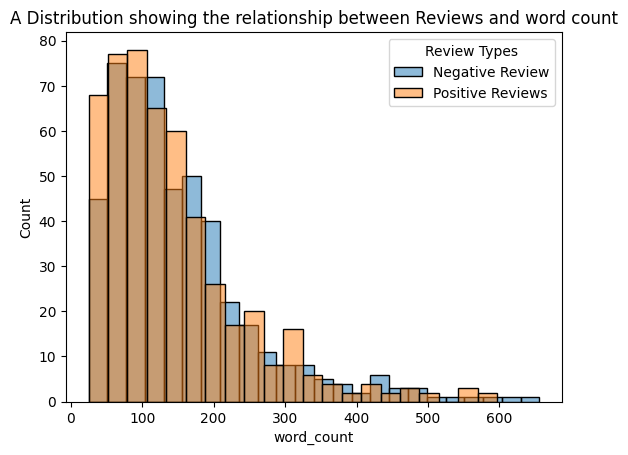

In [44]:
sns.histplot(data = df_reviews[df_reviews['label'] == 'negative']['word_count'], alpha = 0.5, label = "Negative Review")
sns.histplot(data = df_reviews[df_reviews['label'] == 'positive']['word_count'], alpha = 0.5, label = "Positive Reviews")
plt.title("A Distribution showing the relationship between Reviews and word count")
plt.legend(title= "Review Types")
plt.show()

* To discern patterns or differences indicative of specific sentiments based on my chosen engineered features, I visualized the data using Seaborn histograms. My goal was to identify whether certain text attributes — the word count, usage of punctuation, or length of review — aligned with specific sentiment scores, either positive or negative.

* However, my findings suggest no clear distinctions or patterns linking these features to a specific sentiment. The histograms for word count, punctuation, and review length across the different sentiment scores overlapped considerably, implying that these text features are not decisive indicators of sentiment in the dataset.


* While I initially hypothesized that certain characteristics like extensive reviews (longer length, high word count) or excessive punctuation use might correlate with extreme sentiments (very positive or very negative), my analysis doesn't substantiate these assumptions.

* In conclusion, based on the overlap observed in all three histograms, word count, punctuation use, and review length do not appear to be robust or clear indicators of sentiment as per the VADER compound scores. These findings imply the need to explore additional text features or incorporate more complex Natural Language Processing (NLP) methodologies to better predict sentiment from review text. This could include techniques such as TF-IDF, word embeddings, or even more sophisticated machine learning and deep learning models.

In [45]:
df['type of traveller'].value_counts()

type of traveller
Couple Leisure    329
Solo Leisure      316
Business          198
Family Leisure    156
Unknown             1
Name: count, dtype: int64

In [46]:
df['seat_type'].value_counts()

seat_type
Economy Class      561
Business Class     319
Premium Economy     89
First Class         31
Name: count, dtype: int64

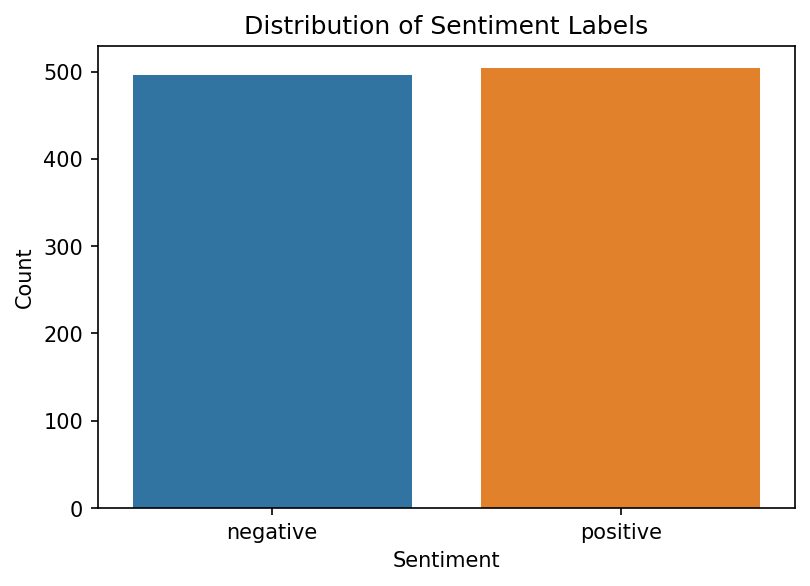

In [47]:
plt.figure(figsize=(6,4), dpi =150)
sns.countplot(x='label', data=df_reviews)

plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.show()

In analyzing the sentiment of 1000 customer reviews of British Airways from 2018 to 2023, it is essential to understand the polarity of opinions/reviews. This helps in assessing the prevailing customer sentiment towards the service and experience.

Out of the total 1000 reviews, the sentiment polarity was closely balanced, with 50.4% positive and 49.6% negative sentiments. 

### Topic Modelling 

In [48]:
# Importing the TfidfVectorizer class from the Scikit-learn library
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating a TF-IDF Vectorizer object
# max_df=0.95: Ignore terms that have a document frequency higher than 95%, i.e., terms that are too common
# min_df=2: Ignore terms that have a document frequency lower than 2, i.e., terms that are too rare
# stop_words='english': Remove English stop words, like 'and', 'the', etc., to reduce dimensionality
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fitting the TF-IDF Vectorizer on the cleaned reviews column and transforming the data
# This step converts the text reviews into a matrix of TF-IDF features
dtm = tfidf.fit_transform(df["reviews_clean"])

# The variable 'dtm' now contains the document-term matrix (sparse matrix) of TF-IDF values
dtm

### NMF

<1000x4015 sparse matrix of type '<class 'numpy.float64'>'
	with 51816 stored elements in Compressed Sparse Row format>

In [49]:
from sklearn.decomposition import NMF

In [50]:
# Importing the NMF class from the Scikit-learn library (assuming it's already imported)

# Creating an NMF model with the following parameters:
# n_components=20: Number of components or topics to extract from the data. This determines the size of the reduced dimensionality.
# random_state=101: Seed used by the random number generator. Setting this ensures reproducibility of results.
nmf = NMF(n_components=20, random_state=101)


In [51]:
# Fitting the NMF model to the document-term matrix (dtm) to extract the specified number of topics or components.
nmf.fit(dtm)

NMF(n_components=20, random_state=101)

In [52]:
print(dir(tfidf))

['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__str__', '__subclasshook__', '__weakref__', '_build_request_for_signature', '_char_ngrams', '_char_wb_ngrams', '_check_feature_names', '_check_n_features', '_check_params', '_check_stop_words_consistency', '_check_vocabulary', '_count_vocab', '_get_default_requests', '_get_metadata_request', '_get_param_names', '_get_tags', '_limit_features', '_more_tags', '_parameter_constraints', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_sort_features', '_stop_words_id', '_tfidf', '_validate_data', '_validate_ngram_range', '_validate_params', '_validate_vocabulary', '_warn_for_unused_params', '_white_spaces', '_word_ng

In [53]:
len(tfidf.get_feature_names_out())

4015

In [54]:
len(nmf.components_)

20

In [55]:
nmf.components_

array([[0.1758962 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01363672, 0.02440537, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04645757, 0.02956819, ..., 0.00221063, 0.        ,
        0.00391278],
       ...,
       [0.        , 0.00897271, 0.        , ..., 0.00145086, 0.        ,
        0.        ],
       [0.01297069, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00064745, 0.        ,
        0.01648668]])

In [56]:
single_topic = nmf.components_[0]

In [57]:
single_topic.argsort()

array([2007, 2405, 2407, ..., 2473, 1347, 1559])

In [58]:
top_word_indices = single_topic.argsort()[-10:]

In [59]:
for index in top_word_indices:
    print(tfidf.get_feature_names_out()[index])

london
flights
terrible
poor
hour
uncomfortable
plane
old
entertainment
food


In [60]:
# Iterating through the components of the NMF model and printing the top 20 words for each topic, 
#identifying key features for each identified topic.
for index, topic in enumerate(nmf.components_):
    print(f"THE TOP 15 WORDS FOR TOPIC #{index}")
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-20:]])
    print("\n")

THE TOP 15 WORDS FOR TOPIC #0
['awful', 'bad', 'aircraft', 'screens', 'selection', 'inflight', 'work', 'cramped', 'screen', 'small', 'london', 'flights', 'terrible', 'poor', 'hour', 'uncomfortable', 'plane', 'old', 'entertainment', 'food']


THE TOP 15 WORDS FOR TOPIC #1
['fees', 'asked', 'called', 'did', 'fee', 'change', 'months', 'refunded', 'travel', 'tickets', 'received', 'email', 'told', 'ticket', 'flight', 'cancel', 'booking', 'paid', 'booked', 'refund']


THE TOP 15 WORDS FOR TOPIC #2
['wife', 'legs', 'window', 'configuration', 'space', 'aircraft', 'pay', 'little', 'uncomfortable', 'leg', 'just', 'sitting', 'middle', 'extra', 'paid', 'legroom', 'aisle', 'row', 'seats', 'seat']


THE TOP 15 WORDS FOR TOPIC #3
['home', 'pm', 'worst', 'day', 'hotel', 'amsterdam', 'heathrow', 'minutes', 'time', 'hour', 'delay', 'airport', 'arrived', 'london', 'late', 'missed', 'connecting', 'hours', 'delayed', 'flight']


THE TOP 15 WORDS FOR TOPIC #4
['madrid', 'make', 'prices', 'able', 'worst', 'f

### Attaching Discovred Topic Labels to Original Reviews 

In [61]:
dtm

<1000x4015 sparse matrix of type '<class 'numpy.float64'>'
	with 51816 stored elements in Compressed Sparse Row format>

In [62]:
dtm.shape

(1000, 4015)

In [63]:
topic_results = nmf.transform(dtm)

In [64]:
topic_results.shape

(1000, 20)

In [65]:
topic_results[0].round(2).argmax()

15

This means that the model thicks that the first review belongs to the topic 16(zero indexed)

In [66]:
# topic_results.argmax(axis =1)

In [67]:
df_reviews['Topic'] = topic_results.argmax(axis = 1)

In [68]:
df_reviews.head(10)

,review,punct%,body_len,polarity_scores,comp_score,label,word_count,Topic
0,Customer Service does not exist One world emerald frequent long haul flyer including BA never...,3.1,772,"{'neg': 0.099, 'neu': 0.836, 'pos': 0.066, 'compound': -0.7266}",-0.7266,negative,174,15
1,Another really great pair of flights on time no problems at all champagne was ok and my meal ch...,2.9,238,"{'neg': 0.064, 'neu': 0.511, 'pos': 0.424, 'compound': 0.9808}",0.9808,positive,53,17
2,Our A380 developed a fault taxiing to the runway we returned to the gate only to then have th...,2.4,845,"{'neg': 0.132, 'neu': 0.789, 'pos': 0.08, 'compound': -0.6936}",-0.6936,negative,191,18
3,Horrible airline Does not care about their customers Used to be decent but has now since really...,2.9,234,"{'neg': 0.125, 'neu': 0.875, 'pos': 0.0, 'compound': -0.7063}",-0.7063,negative,55,3
4,My family and I have flown mostly on British Airways for the last 30 years I am a priority pas...,2.4,1276,"{'neg': 0.036, 'neu': 0.886, 'pos': 0.077, 'compound': 0.919}",0.9190,positive,307,7
5,This has been by far the worst service I have had on a plane Its very obvious that if you are ...,2.5,550,"{'neg': 0.062, 'neu': 0.887, 'pos': 0.05, 'compound': -0.3923}",-0.3923,negative,136,11
6,In Nov 2022 I booked and paid for a return journey to New Zealand On my return journey my fina...,2.4,808,"{'neg': 0.087, 'neu': 0.886, 'pos': 0.027, 'compound': -0.9281}",-0.9281,negative,198,1
7,BA is not treating its premium economy passengers with respect You pay for a premium economy se...,2.3,173,"{'neg': 0.037, 'neu': 0.849, 'pos': 0.114, 'compound': 0.4404}",0.4404,positive,38,11
8,24 hours before our departure on BA059 to Cape Town from Heathrow on Thursday 29th June we did...,2.4,1325,"{'neg': 0.062, 'neu': 0.884, 'pos': 0.053, 'compound': -0.2558}",-0.2558,negative,320,2
9,We arrived at Heathrow at 0600 to find our flight to Ibiza was cancelled by BA with no explana...,2.2,483,"{'neg': 0.169, 'neu': 0.791, 'pos': 0.041, 'compound': -0.9011}",-0.9011,negative,102,18


In [69]:
df_final = df_reviews[['review', 'label', 'Topic']]

In [70]:
df_final = pd.concat([df_final, df[[ 'date', 'seat_type']]], axis = 1)

In [71]:
df_final.head(10)

,review,label,Topic,date,seat_type
0,Customer Service does not exist One world emerald frequent long haul flyer including BA never...,negative,15,July 2023,Business Class
1,Another really great pair of flights on time no problems at all champagne was ok and my meal ch...,positive,17,June 2023,Business Class
2,Our A380 developed a fault taxiing to the runway we returned to the gate only to then have th...,negative,18,June 2023,Business Class
3,Horrible airline Does not care about their customers Used to be decent but has now since really...,negative,3,July 2023,Economy Class
4,My family and I have flown mostly on British Airways for the last 30 years I am a priority pas...,positive,7,July 2023,Premium Economy
5,This has been by far the worst service I have had on a plane Its very obvious that if you are ...,negative,11,July 2023,Economy Class
6,In Nov 2022 I booked and paid for a return journey to New Zealand On my return journey my fina...,negative,1,November 2022,Economy Class
7,BA is not treating its premium economy passengers with respect You pay for a premium economy se...,positive,11,June 2023,Premium Economy
8,24 hours before our departure on BA059 to Cape Town from Heathrow on Thursday 29th June we did...,negative,2,June 2023,Economy Class
9,We arrived at Heathrow at 0600 to find our flight to Ibiza was cancelled by BA with no explana...,negative,18,July 2023,Economy Class


In [72]:
# df_final[df_final['Topic'] == 10]['review'].iloc[4]

In [73]:
topic_name = {
    0: "Inflight experience,Seat and Legroom issues",
    1: "Booking and ticketing issues",
    2: "Inflight experience,Seat and Legroom issues",
    3: "Flight delays or cancellations",
    4: "Overall Negative Experience",
    5: "Customer Service",
    6: "Baggage handling",
    7: "Overall Negative Experience",
    8: "Customer Service",
    9: "Inflight experience,Seat and Legroom issues",
    10: "Inflight experience,Seat and Legroom issues",
    11: "Inflight experience,Seat and Legroom issues",
    12: "Baggage handling",
    13: "Customer Service",
    14: "Customer Service",
    15: "Booking and ticketing issues",
    16: "Booking and ticketing issues",
    17: "Overall Positive Experience",
    18: "Booking and ticketing issues",
    19: "Overall Positive Experience"
}

*Mapping the numerical topic identifiers to human-readable labels, to provide context and make interpretation of the topics more intuitive.*

In [74]:
df_final['Topic Label'] = df_final["Topic"].map(topic_name)

In [75]:
df_final.columns

Index(['review', 'label', 'Topic', 'date', 'seat_type', 'Topic Label'], dtype='object')

In [76]:
df_final['Topic Label'].value_counts()

Topic Label
Customer Service                               230
Inflight experience,Seat and Legroom issues    221
Booking and ticketing issues                   170
Overall Positive Experience                    145
Overall Negative Experience                    109
Baggage handling                                70
Flight delays or cancellations                  55
Name: count, dtype: int64

In [77]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review       1000 non-null   object
 1   label        1000 non-null   object
 2   Topic        1000 non-null   int64 
 3   date         1000 non-null   object
 4   seat_type    1000 non-null   object
 5   Topic Label  1000 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.0+ KB


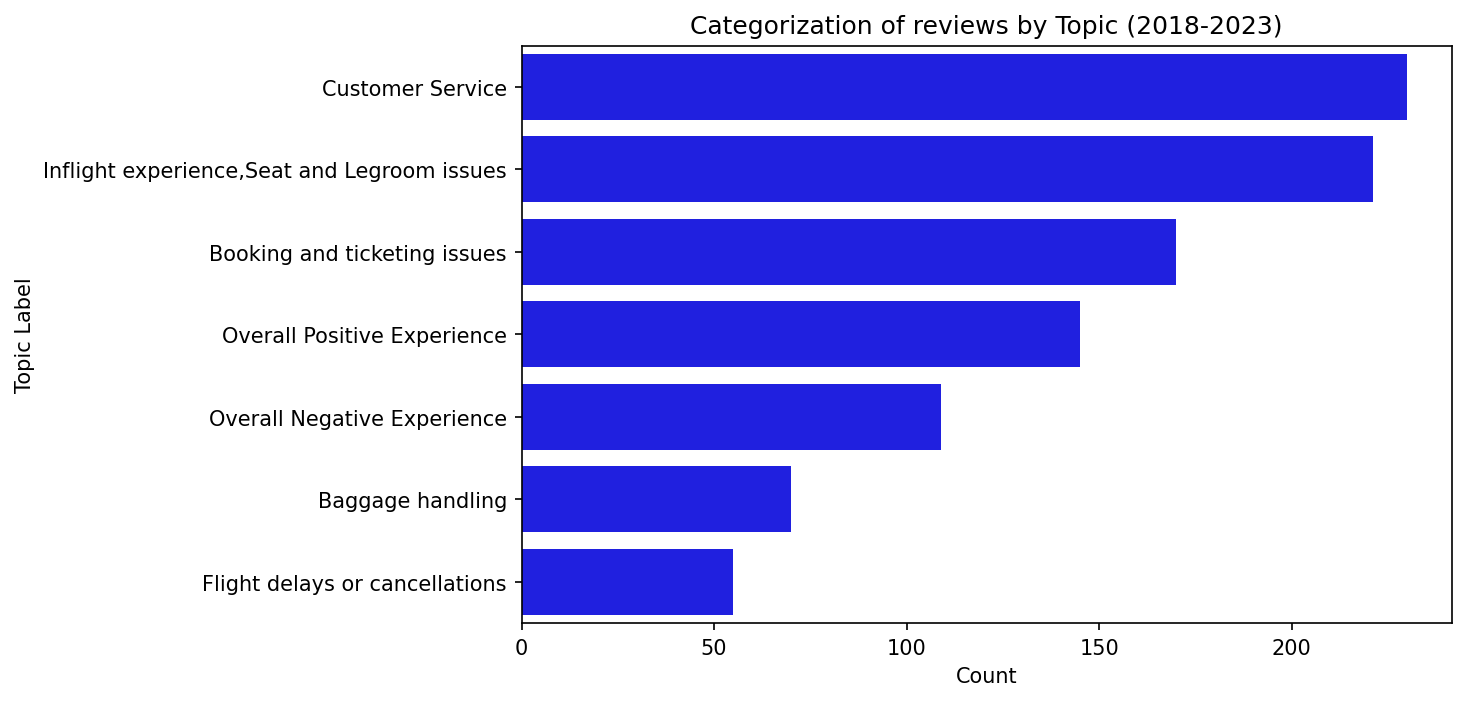

In [78]:
# Get the counts
counts = df_final['Topic Label'].value_counts()

# Create the figure and axes objects
plt.figure(figsize=(8,5), dpi = 150)

# Plot the data
sns.barplot(x=counts.values, y=counts.index, color='blue')

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Topic Label')
plt.title('Categorization of reviews by Topic (2018-2023)')
# plt.xticks(rotation=20)

# # Save the plot
# plt.savefig('categorization18_23.png', bbox_inches='tight', dpi =200)


# Show the plot
plt.show()

In [79]:
df_final['date'] = pd.to_datetime(df_final['date'])

In [80]:
df_final['month_year'] = df_final['date'].dt.to_period('M')

In [81]:
df_final.columns

Index(['review', 'label', 'Topic', 'date', 'seat_type', 'Topic Label',
       'month_year'],
      dtype='object')

In [82]:
df_final['month_year'].unique()

<PeriodArray>
['2023-07', '2023-06', '2022-11', '2023-05', '2023-03', '2023-04', '2023-02',
 '2022-09', '2023-01', '2022-05', '2022-12', '2022-04', '2022-10', '2022-06',
 '2022-01', '2022-08', '2022-07', '2021-11', '2021-07', '2022-02', '2022-03',
 '2021-08', '2021-10', '2021-12', '2021-01', '2021-09', '2020-11', '2020-10',
 '2021-04', '2021-06', '2021-05', '2020-12', '2021-02', '2020-09', '2020-07',
 '2019-11', '2020-08', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
 '2019-12', '2019-08', '2019-10', '2020-01', '2019-07', '2019-09', '2019-04',
 '2019-05', '2019-02', '2018-11', '2019-06', '2018-09', '2018-10', '2019-01',
 '2019-03', '2018-12', '2018-04', '2018-03', '2018-08', '2018-02', '2018-06',
 '2018-07']
Length: 64, dtype: period[M]

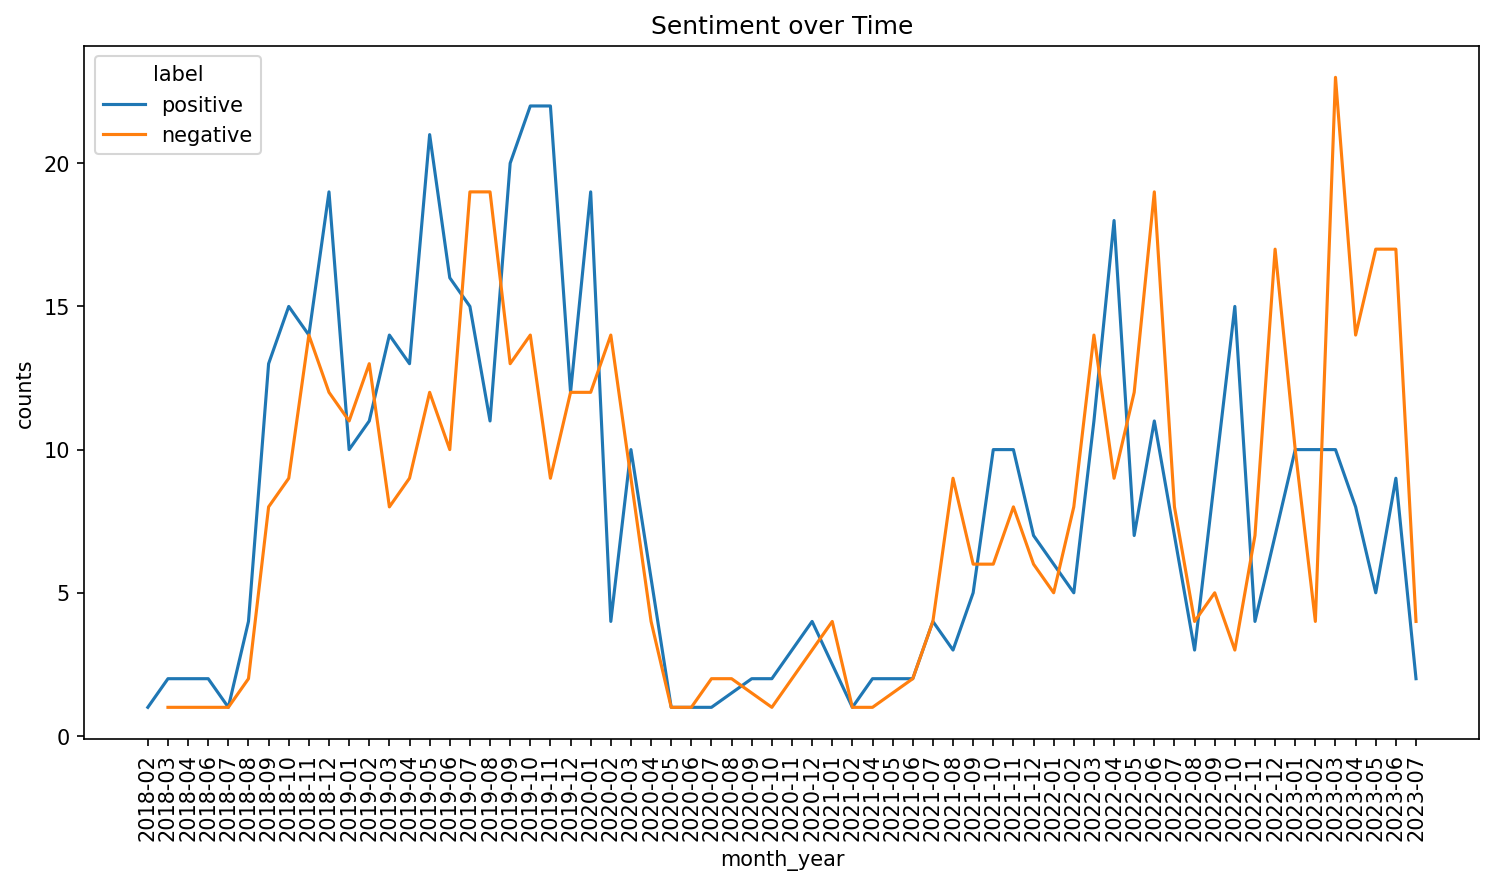

In [83]:
data = df_final.groupby(['month_year', 'label']).size().reset_index(name='counts')
data['counts'] = data['counts'].astype(int)
data['month_year'] = data['month_year'].astype(str)

# Specify the colors
colors = ['red', 'blue']  # Change these to your desired colors

plt.figure(figsize=(12,6), dpi = (150))
sns.lineplot(data=data, x='month_year', y='counts', hue='label', color =colors)
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.title('Sentiment over Time')

# Save the plot
# plt.savefig('sentiment18_23.png', bbox_inches='tight', dpi =200)


plt.show()

In [84]:
df_final['seat_type'].unique()

array(['Business Class', 'Economy Class', 'Premium Economy',
       'First Class'], dtype=object)

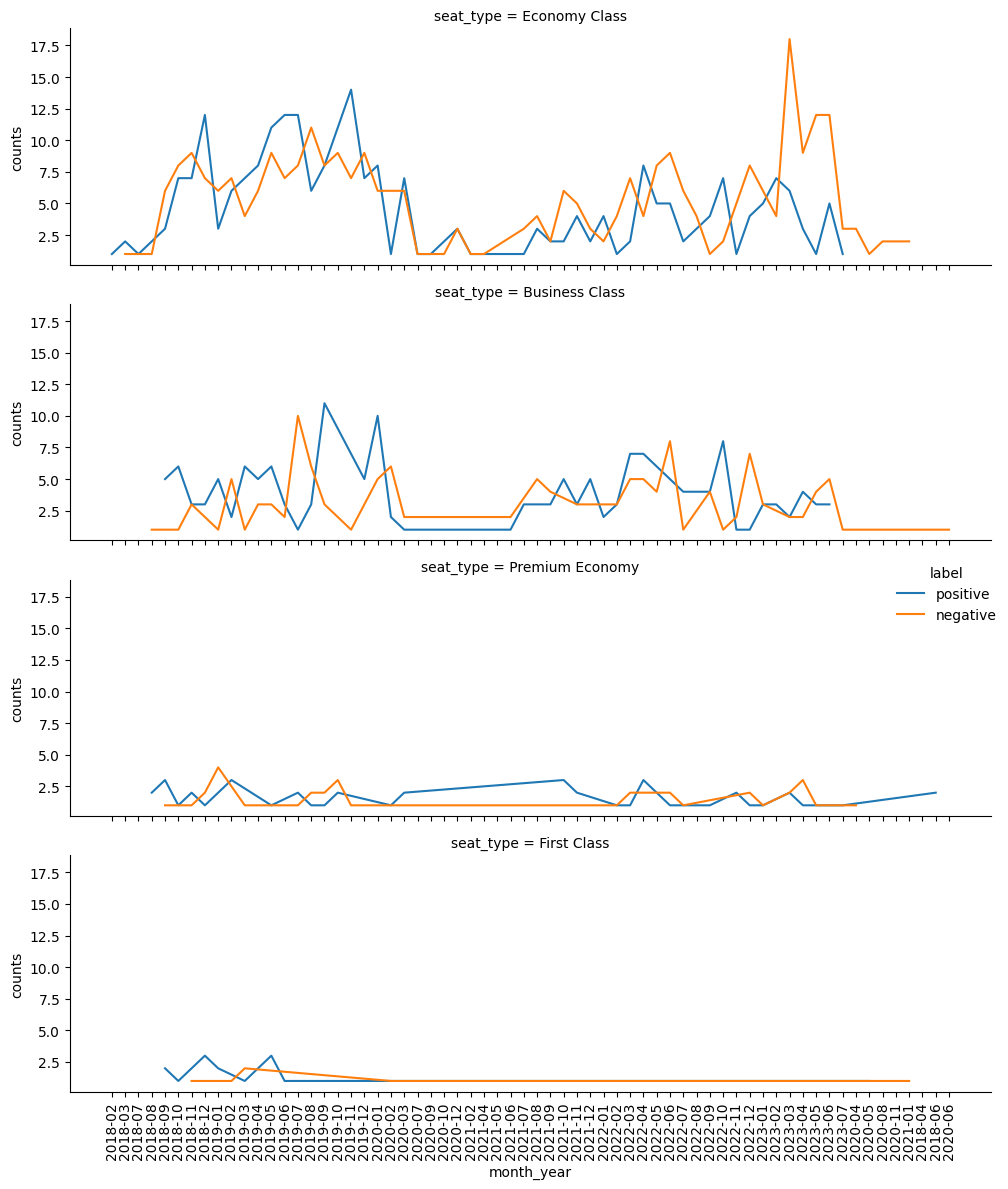

In [85]:
data = df_final.groupby(['month_year', 'label', 'seat_type']).size().reset_index(name='counts')

# convert 'month_year' to string again to ensure compatibility with Seaborn
data['month_year'] = data['month_year'].astype(str)

g = sns.FacetGrid(data, row='seat_type', hue='label', aspect=3)
g.map(sns.lineplot, 'month_year', 'counts')
g.add_legend()

# Rotate x-axis labels for better readability
for ax in g.axes.flatten():
    for tick in ax.get_xticklabels():
        tick.set(rotation=90)

plt.tight_layout()
plt.show()

In [86]:
df_final['Topic Label'].value_counts()

Topic Label
Customer Service                               230
Inflight experience,Seat and Legroom issues    221
Booking and ticketing issues                   170
Overall Positive Experience                    145
Overall Negative Experience                    109
Baggage handling                                70
Flight delays or cancellations                  55
Name: count, dtype: int64

In [87]:
df_final.head()

,review,label,Topic,date,seat_type,Topic Label,month_year
0,Customer Service does not exist One world emerald frequent long haul flyer including BA never...,negative,15,2023-07-01,Business Class,Booking and ticketing issues,2023-07
1,Another really great pair of flights on time no problems at all champagne was ok and my meal ch...,positive,17,2023-06-01,Business Class,Overall Positive Experience,2023-06
2,Our A380 developed a fault taxiing to the runway we returned to the gate only to then have th...,negative,18,2023-06-01,Business Class,Booking and ticketing issues,2023-06
3,Horrible airline Does not care about their customers Used to be decent but has now since really...,negative,3,2023-07-01,Economy Class,Flight delays or cancellations,2023-07
4,My family and I have flown mostly on British Airways for the last 30 years I am a priority pas...,positive,7,2023-07-01,Premium Economy,Overall Negative Experience,2023-07


In [88]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review       1000 non-null   object        
 1   label        1000 non-null   object        
 2   Topic        1000 non-null   int64         
 3   date         1000 non-null   datetime64[ns]
 4   seat_type    1000 non-null   object        
 5   Topic Label  1000 non-null   object        
 6   month_year   1000 non-null   period[M]     
dtypes: datetime64[ns](1), int64(1), object(4), period[M](1)
memory usage: 54.8+ KB


In [89]:
df_final_22_23 = df_final[df_final['month_year'] > "2021-12"]

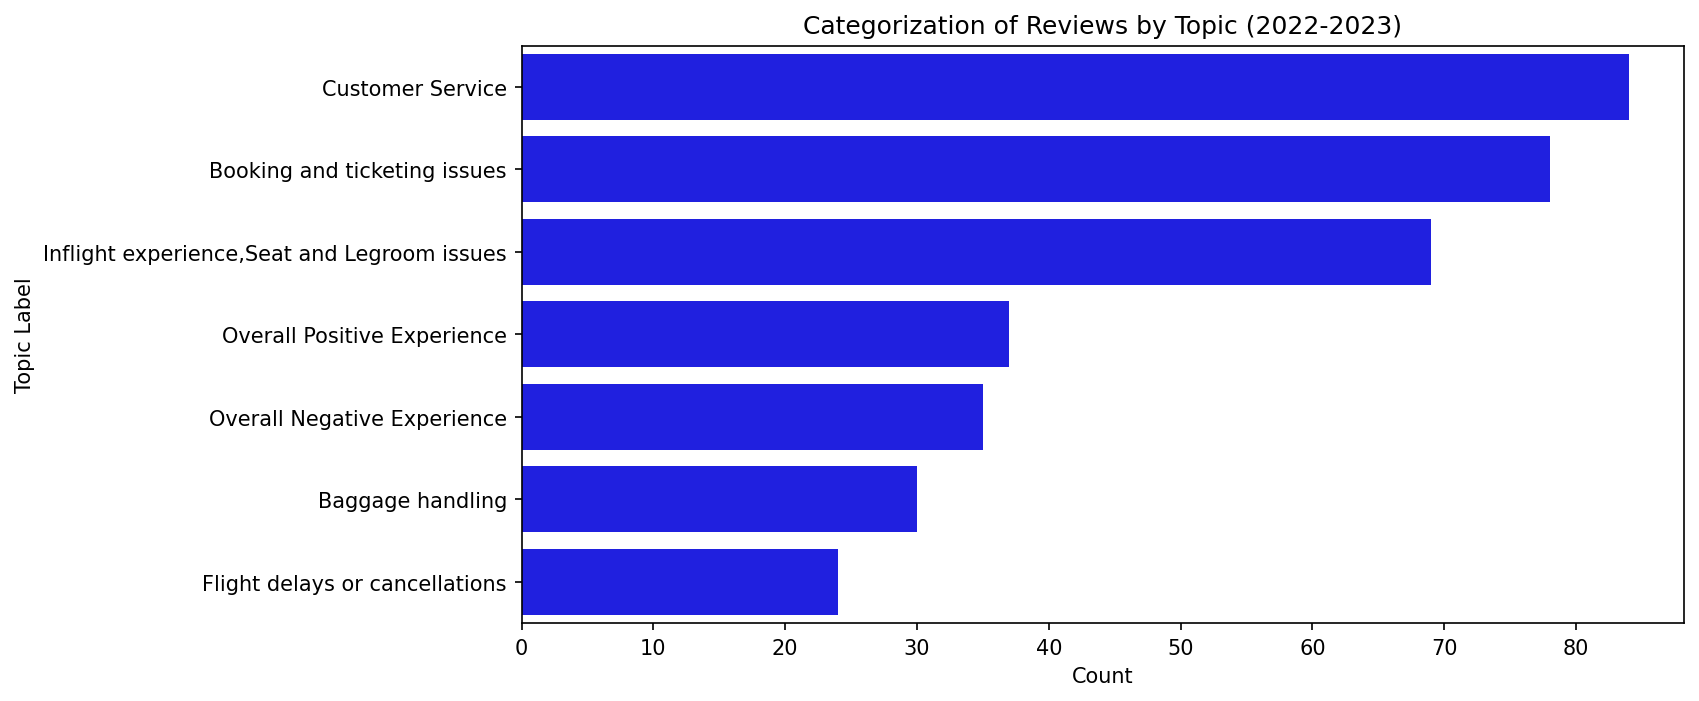

In [90]:
# Get the counts
counts = df_final_22_23['Topic Label'].value_counts()

# Create the figure and axes objects
plt.figure(figsize=(10,5), dpi = 150)

# Plot the data
sns.barplot(x=counts.values, y=counts.index, color='blue')

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Topic Label')
plt.title('Categorization of Reviews by Topic (2022-2023)')

# Save the plot
# plt.savefig('topic22_23.png', bbox_inches='tight', dpi =200)
# Show the plot
plt.show()

In [91]:
df_final_22_23.head()

,review,label,Topic,date,seat_type,Topic Label,month_year
0,Customer Service does not exist One world emerald frequent long haul flyer including BA never...,negative,15,2023-07-01,Business Class,Booking and ticketing issues,2023-07
1,Another really great pair of flights on time no problems at all champagne was ok and my meal ch...,positive,17,2023-06-01,Business Class,Overall Positive Experience,2023-06
2,Our A380 developed a fault taxiing to the runway we returned to the gate only to then have th...,negative,18,2023-06-01,Business Class,Booking and ticketing issues,2023-06
3,Horrible airline Does not care about their customers Used to be decent but has now since really...,negative,3,2023-07-01,Economy Class,Flight delays or cancellations,2023-07
4,My family and I have flown mostly on British Airways for the last 30 years I am a priority pas...,positive,7,2023-07-01,Premium Economy,Overall Negative Experience,2023-07


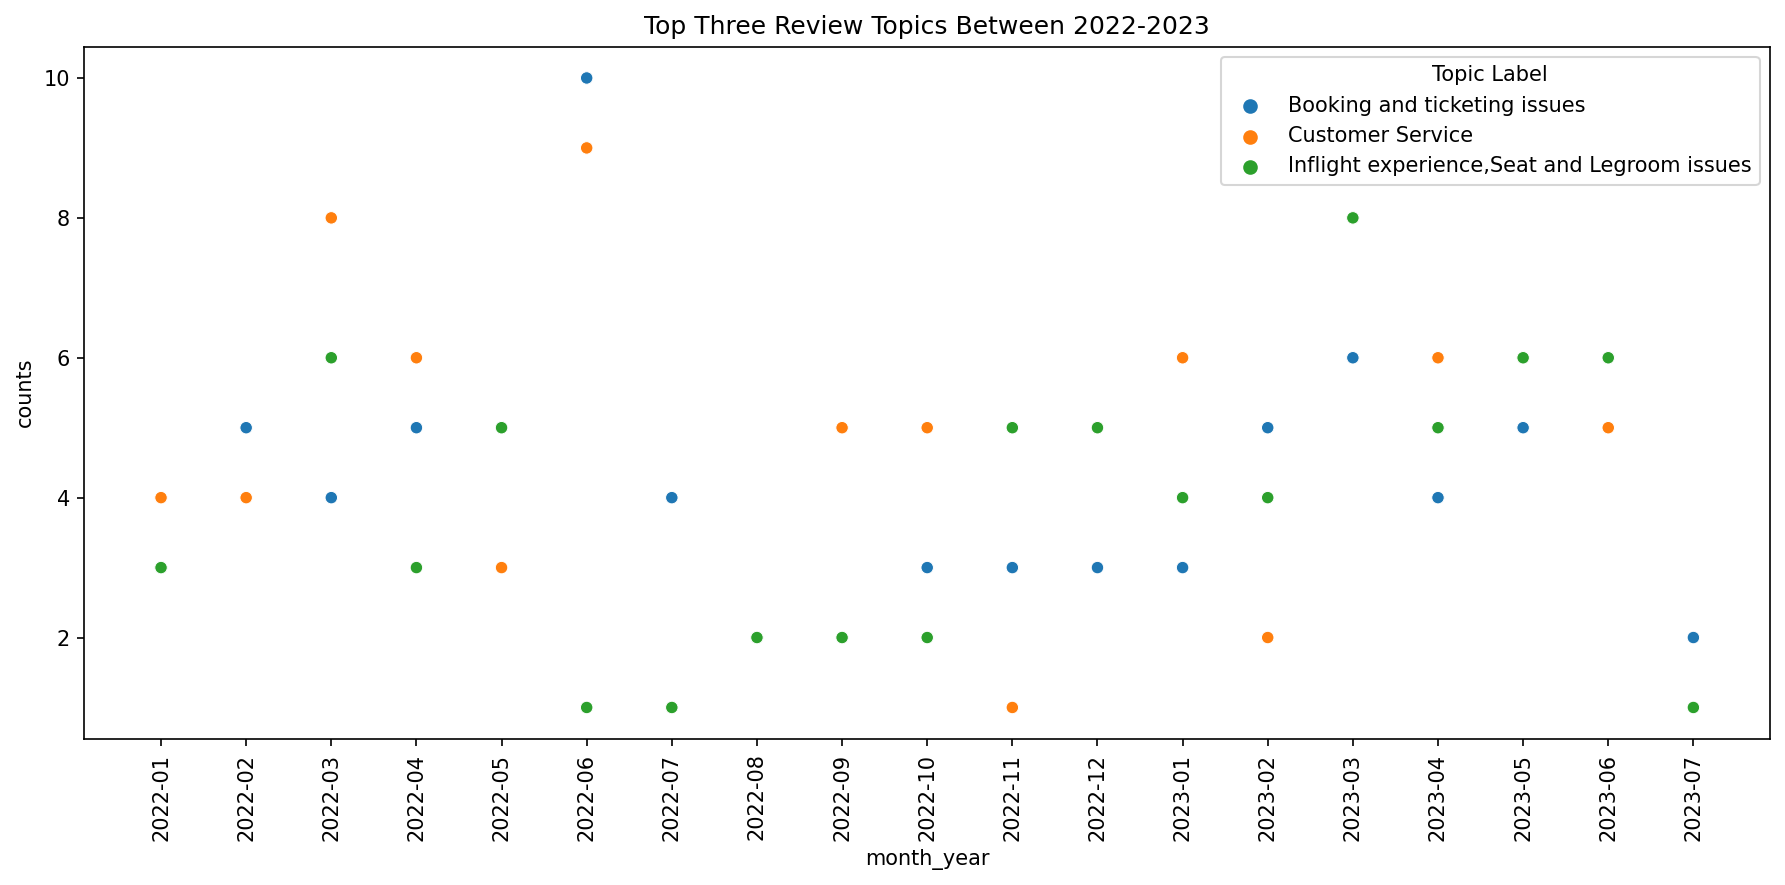

In [92]:
data = df_final_22_23[df_final_22_23['Topic Label'].isin(['Booking and ticketing issues', 
                                                          'Customer Service', 
                                                          'Inflight experience,Seat and Legroom issues'])]
# convert 'month_year' to string again to ensure compatibility with Seaborn
data['month_year'] = data['month_year'].astype(str)


# Group data by 'month_year' and 'Topic Label', and get count for each group
data_grouped = data.groupby(['month_year', 'Topic Label']).size().reset_index(name='counts')

# Create scatter plot
plt.figure(figsize=(12,6), dpi=150)
sns.scatterplot(data=data_grouped, x='month_year', y='counts', hue='Topic Label')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.title('Top Three Review Topics Between 2022-2023')
plt.tight_layout()

# Save the plot
# plt.savefig('filename.png')

plt.show()

<Figure size 1050x1050 with 0 Axes>

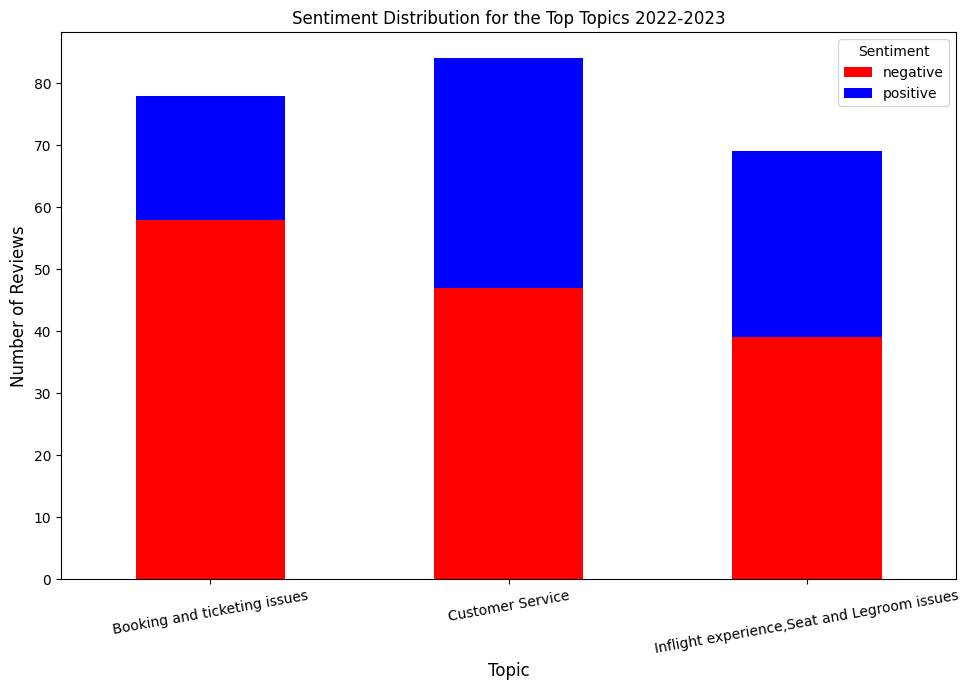

In [93]:
data = df_final_22_23[df_final_22_23['Topic Label'].isin(['Booking and ticketing issues', 
                                                          'Customer Service', 
                                                          'Inflight experience,Seat and Legroom issues'])]
# convert 'month_year' to string again to ensure compatibility with Seaborn
data['month_year'] = data['month_year'].astype(str)
grouped = data.groupby(['Topic Label', 'label']).size().unstack()

# Specify the colors
colors = ['red', 'blue']  # Change these to your desired colors

# Plot a stacked bar chart
plt.figure(figsize=(7,7), dpi = 150)
grouped.plot(kind='bar', stacked=True, figsize=(10,7), color = colors)

plt.title('Sentiment Distribution for the Top Topics 2022-2023')
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=10)
plt.legend(title='Sentiment')
plt.tight_layout()
# Save the plot
# plt.savefig('sentidist22_23.png', bbox_inches='tight', dpi =200)

plt.show()

In [94]:
# Filter data for 2018-2021
data_18_21 = df_final[(df_final['date'] >= '2018-01-01') & (df_final['date'] <= '2021-12-01')]
# Filter data for 2022-2023
data_22_23 = df_final[(df_final['date'] >= '2022-01-01') & (df_final['date'] <= '2023-07-01')]

# Calculate percentages for both time frames
percent_negative_18_21 = round((data_18_21['label'] == 'negative').mean(), 2) * 100
percent_positive_18_21 = round((data_18_21['label'] == 'positive').mean(), 2) * 100
percent_negative_22_23 = round((data_22_23['label'] == 'negative').mean(), 2) * 100
percent_positive_22_23 = round((data_22_23['label'] == 'positive').mean(), 2) * 100


print(f"At least, {percent_negative_18_21}% of the reviews had a negative sentiments from 2018 to 2021")
print(f"At least, {percent_negative_22_23}% of the reviews had a negative sentiments from 2022 to 2023")

At least, 46.0% of the reviews had a negative sentiments from 2018 to 2021
At least, 56.00000000000001% of the reviews had a negative sentiments from 2022 to 2023


In [101]:
booking_topic = data_22_23[(data_22_23['label'] == 'negative') & (data_22_23['Topic Label'] == 'Booking and ticketing issues')]

book_neg = round(len(booking_topic)/len(data_22_23[(data_22_23['Topic Label'] == 'Booking and ticketing issues')]) * 100,2)

print(f"At least, {book_neg}% of the reviews had a negative sentiments on booking and ticketing issues from 2022 to 2023")

At least, 74.36% of the reviews had a negative sentiments on booking and ticketing issues from 2022 to 2023
